## Etapa 1: Importação das bibliotecas

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
torch.__version__

'1.13.1+cu116'

In [2]:
torch.manual_seed(123)

## Etapa 2: Construção do modelo

In [3]:
classificador = nn.Sequential(
                              nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(32, 32, 3),
                              nn.ReLU(),
                              nn.MaxPool2d(2),
                              nn.Flatten(),
                              nn.Linear(in_features = 14*14*32, out_features = 4),
                              nn.ReLU(),
                              nn.Linear(4, 4),
                              nn.ReLU(),
                              nn.Linear(4, 1),
                              nn.Sigmoid()
                              )

In [4]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

## Etapa 3: Base de dados

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path = '/content/gdrive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/dataset_personagens.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [9]:
data_dir_train = '/content/dataset_personagens/training_set'
data_dir_test = '/content/dataset_personagens/test_set'

In [10]:
transform_train = transforms.Compose([
                                      transforms.Resize([64, 64]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees = 7, 
                                                              translate = (0, 0.07),
                                                              shear = 0.2,
                                                              scale = (1, 1.2)
                                                              ),
                                      transforms.ToTensor()
                                      ])

In [11]:
transform_test = transforms.Compose([
                                     transforms.Resize([64, 64]),
                                     transforms.ToTensor()
                                     ])

In [12]:
train_dataset = datasets.ImageFolder(data_dir_train, transform = transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 10, shuffle = True)

In [13]:
test_dataset = datasets.ImageFolder(data_dir_test, transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle = True)

## Etapa 4: Treinamento e avaliação

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [15]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=4, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4, out_features=4, bias=True)
  (10): ReLU()
  (11): Linear(in_features=4, out_features=1, bias=True)
  (12): Sigmoid()
)

In [16]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        

        outputs = classificador(inputs)
                
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        running_loss += loss.item()
        loss.backward()
        
        optimizer.step()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        equals = predicted == labels.view(*predicted.shape)
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
      
        # Imprimindo os dados referentes a esse loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, accuracy), end = '\r')
        
    # Imprimindo os dados referentes a essa época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), running_accuracy/len(loader)))

In [17]:
for epoch in range(100):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    classificador.train()

Treinando...
ÉPOCA   1 FINALIZADA: perda 0.66976 - precisão 0.60667
Validando...
ÉPOCA   1 FINALIZADA: perda 0.65554 - precisão 0.61250
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.64320 - precisão 0.70167
Validando...
ÉPOCA   2 FINALIZADA: perda 0.60807 - precisão 0.74583
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.61225 - precisão 0.74667
Validando...
ÉPOCA   3 FINALIZADA: perda 0.55814 - precisão 0.77500
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.60686 - precisão 0.76833
Validando...
ÉPOCA   4 FINALIZADA: perda 0.53045 - precisão 0.75417
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.59738 - precisão 0.75000
Validando...
ÉPOCA   5 FINALIZADA: perda 0.49240 - precisão 0.87083
Treinando...
ÉPOCA   6 FINALIZADA: perda 0.58423 - precisão 0.76667
Validando...
ÉPOCA   6 FINALIZADA: perda 0.46372 - precisão 0.85000
Treinando...
ÉPOCA   7 FINALIZADA: perda 0.56587 - precisão 0.79000
Validando...
ÉPOCA   7 FINALIZADA: perda 0.42674 - precisão 0.88750
Treinando...
ÉPOCA   8 FINALIZADA: perda 0.57075

## Etapa 5: Avaliação do modelo

In [18]:
def classificar_imagem(fname):
  from PIL import Image
  import matplotlib.pyplot as plt
  imagem_teste = Image.open(data_dir_test + '/' + fname)
  plt.imshow(imagem_teste)

  import numpy as np
  imagem_teste = imagem_teste.resize((64, 64))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  output = classificador.forward(imagem_teste)
  if output > 0.5:
    output = 1
  else:
    output = 0
  print('Previsão: ', output)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

  return idx_to_class[output]

Previsão:  0


'bart'

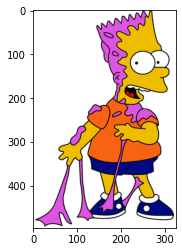

In [19]:
imagem = '/bart/bart1.bmp'
classificar_imagem(imagem)

Previsão:  1


'homer'

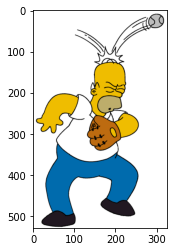

In [20]:
imagem = '/homer/homer7.bmp'
classificar_imagem(imagem)